In [1]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/gt-big-data/solar-forecasting/master/analysis/2019-data/980023_33.89_-83.90_2019.csv', header = 2)
df.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm),Unnamed: 24
0,2019,1,1,0,0,0,0,0,0,0,0,7,16.2,166.18,0,0.09,0.4,4.0,215,100.0,16.2,980,0.0,0.0,NaN
1,2019,1,1,0,30,0,0,0,0,0,0,7,16.2,168.95,0,0.09,0.3,3.9,234,100.0,16.2,980,0.0,0.0,NaN
2,2019,1,1,1,0,0,0,0,0,0,0,4,16.1,168.18,0,0.09,0.3,3.9,252,100.0,16.1,981,0.0,0.0,NaN
3,2019,1,1,1,30,0,0,0,0,0,0,3,15.9,164.40,0,0.09,0.3,3.8,273,100.0,15.9,981,0.0,0.0,NaN
4,2019,1,1,2,0,0,0,0,0,0,0,4,15.6,159.19,0,0.09,0.3,3.7,293,100.0,15.6,981,0.0,0.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Year                                         17520 non-null  int64  
 1   Month                                        17520 non-null  int64  
 2   Day                                          17520 non-null  int64  
 3   Hour                                         17520 non-null  int64  
 4   Minute                                       17520 non-null  int64  
 5   DHI                                          17520 non-null  int64  
 6   DNI                                          17520 non-null  int64  
 7   GHI                                          17520 non-null  int64  
 8   Clearsky DHI                                 17520 non-null  int64  
 9   Clearsky DNI                                 17520 non-null  int64  
 10

In [4]:
df['Date'] = pd.to_datetime(df[['Minute','Hour','Day','Month','Year']])
df.index = range(0, df.shape[0])

# To look at only a month's worth of data
jan_df = df[df['Month'] == 1]

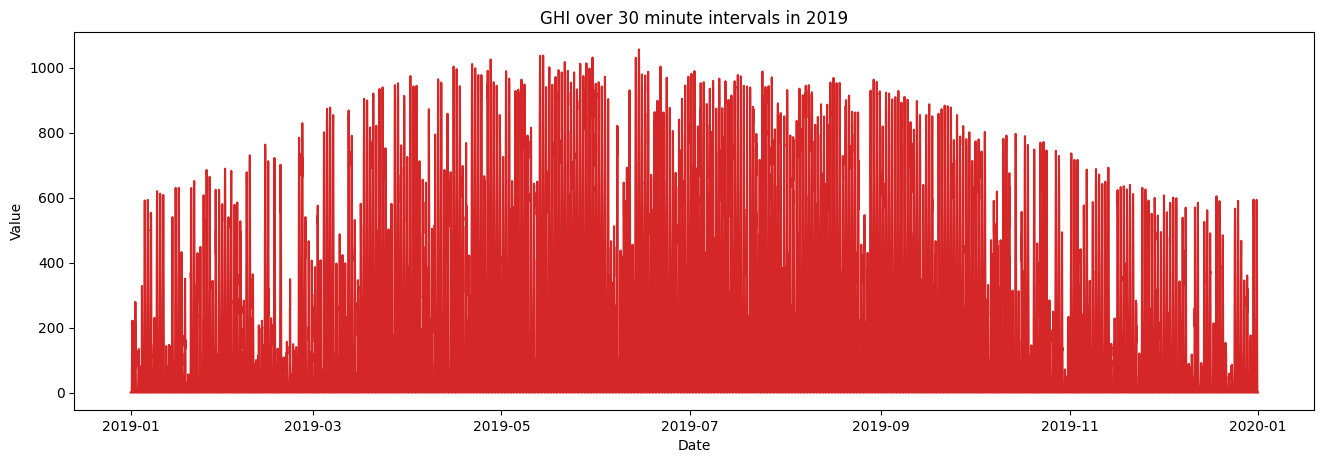

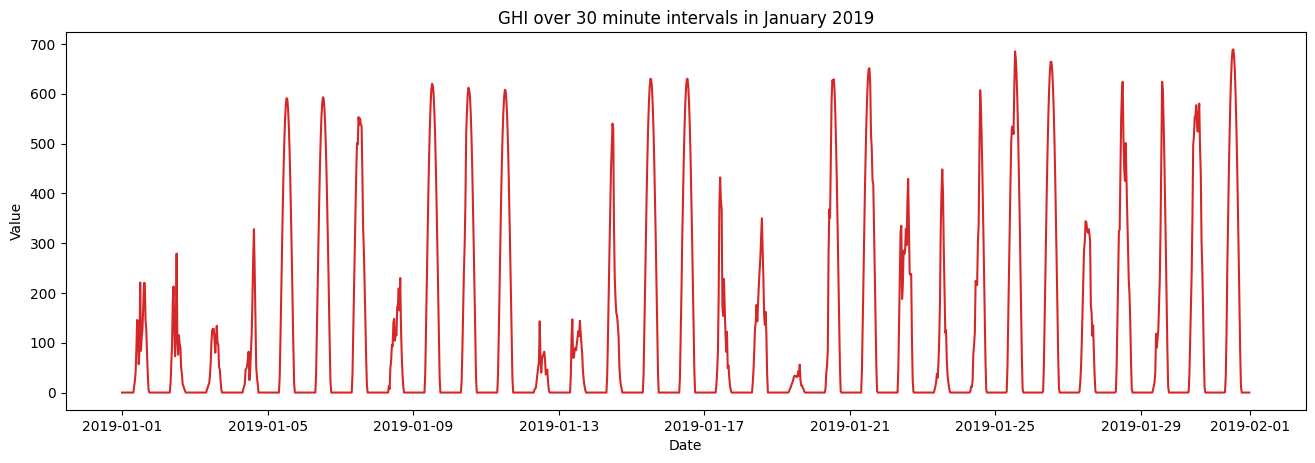

In [5]:
import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    #set proportions of figure and resolution(100)
    plt.figure(figsize=(16,5), dpi=dpi)
    #plots the index against value, in this case, dates against values
    plt.plot(x, y, color='tab:red')
    #gca gets the titles
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Date, y=df.GHI, title='GHI over 30 minute intervals in 2019') 
plot_df(jan_df, x=jan_df.Date, y=jan_df.GHI, title='GHI over 30 minute intervals in January 2019') 

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(df.GHI.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.41685521151386
p-value: 1.8322046492343358e-08
Critial Values:
   1%, -3.4307242638530675
Critial Values:
   5%, -2.861705410152796
Critial Values:
   10%, -2.5668580435332715


In [7]:
!pip3 install pmdarima

# from pmdarima.arima.utils import ndiffs
# import pandas as pd
# y = df.GHI

# ## Adf Test
# ndiffs(y, test='adf')

# the adfuller test and ndiffs tells us that d is 0

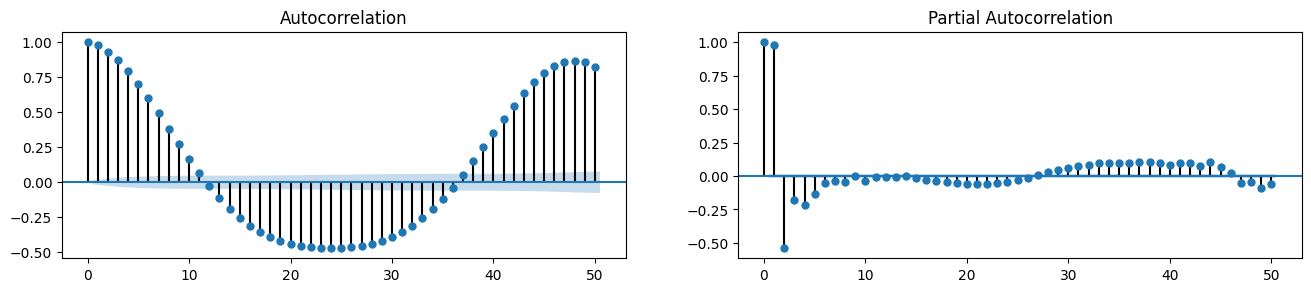

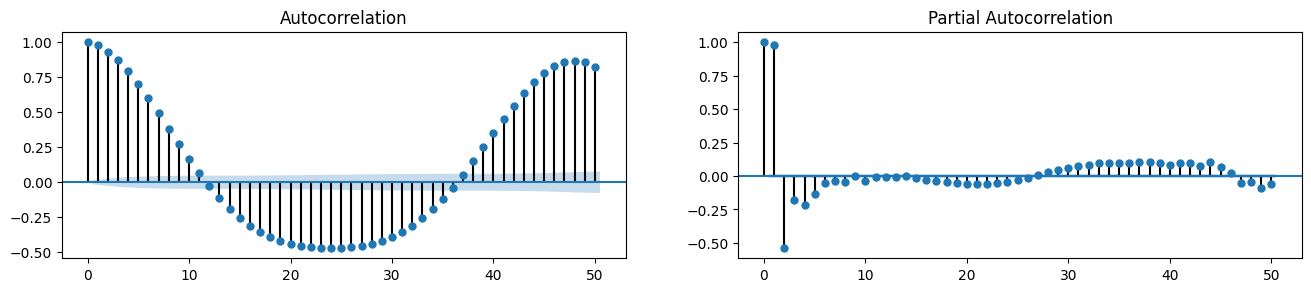

In [8]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi= 100)
plot_acf(df.GHI.tolist(), lags=50, ax=axes[0])
plot_pacf(df.GHI.tolist(), lags=50, ax=axes[1])

# pacf shows first 2 lags cross significance limit, so we know that p = 2

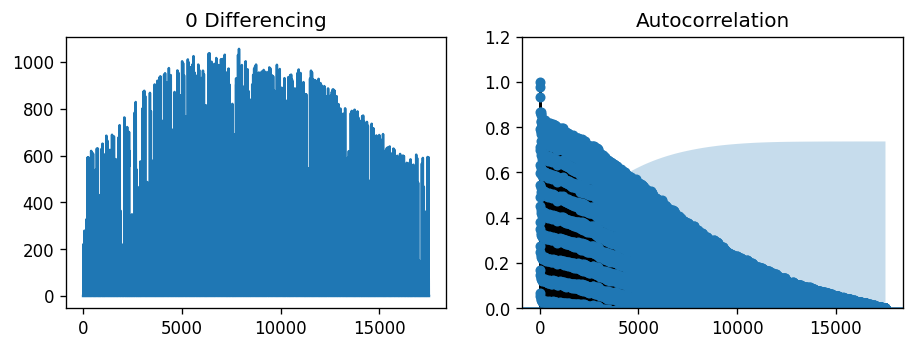

In [9]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.GHI)
axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.GHI.dropna(), ax=axes[1], lags=df.GHI.shape[0] - 2)

plt.show()

# acf shows that first three values are well above significance boundary, so we know that q is 3

In [10]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI', 'GHI',
       'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Fill Flag', 'Surface Albedo',
       'Wind Speed', 'Precipitable Water', 'Wind Direction',
       'Relative Humidity', 'Temperature', 'Pressure',
       'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)', 'Unnamed: 24', 'Date'],
      dtype='object')

In [11]:
data_missing = df.isna()
data_missing_count = data_missing.sum()
data_missing_count / len(df)

# If we are missing more than 25% of the data for hive_humidity and ambient_humidity, we should drop those variables as they may impact our results
columns_to_drop = []
for column in df.columns:
    drop_percentage = df[column].isna().sum() / len(df[column])
    if drop_percentage > 0.1:
      columns_to_drop.append(column)

df = df.drop(columns = columns_to_drop)

# To deal with any missing data, we can perform a backwards fill and then a forward fill on missing data
df =  df.fillna(method='bfill').fillna(method='ffill')

print(df.isna().sum())

df

Year                                           0
Month                                          0
Day                                            0
Hour                                           0
Minute                                         0
DHI                                            0
DNI                                            0
GHI                                            0
Clearsky DHI                                   0
Clearsky DNI                                   0
Clearsky GHI                                   0
Cloud Type                                     0
Dew Point                                      0
Solar Zenith Angle                             0
Fill Flag                                      0
Surface Albedo                                 0
Wind Speed                                     0
Precipitable Water                             0
Wind Direction                                 0
Relative Humidity                              0
Temperature         

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm),Date
0,2019,1,1,0,0,0,0,0,0,0,0,7,16.2,166.18,0,0.09,0.4,4.0,215,100.00,16.2,980,0.0,0.0,2019-01-01 00:00:00
1,2019,1,1,0,30,0,0,0,0,0,0,7,16.2,168.95,0,0.09,0.3,3.9,234,100.00,16.2,980,0.0,0.0,2019-01-01 00:30:00
2,2019,1,1,1,0,0,0,0,0,0,0,4,16.1,168.18,0,0.09,0.3,3.9,252,100.00,16.1,981,0.0,0.0,2019-01-01 01:00:00
3,2019,1,1,1,30,0,0,0,0,0,0,3,15.9,164.40,0,0.09,0.3,3.8,273,100.00,15.9,981,0.0,0.0,2019-01-01 01:30:00
4,2019,1,1,2,0,0,0,0,0,0,0,4,15.6,159.19,0,0.09,0.3,3.7,293,100.00,15.6,981,0.0,0.0,2019-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2019,12,31,21,30,0,0,0,0,0,0,3,16.2,137.48,0,0.09,0.7,3.4,204,98.51,16.4,980,0.0,0.0,2019-12-31 21:30:00
17516,2019,12,31,22,0,0,0,0,0,0,0,0,16.1,143.68,0,0.09,0.7,3.5,205,99.30,16.2,980,0.0,0.0,2019-12-31 22:00:00
17517,2019,12,31,22,30,0,0,0,0,0,0,0,16.1,149.81,0,0.09,0.7,3.7,206,99.30,16.2,980,0.0,0.0,2019-12-31 22:30:00
17518,2019,12,31,23,0,0,0,0,0,0,0,0,16.3,155.78,0,0.09,0.7,3.8,208,100.00,16.3,980,0.0,0.0,2019-12-31 23:00:00


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
No handles with labels found to put in legend.


                              ARMA Model Results                              
Dep. Variable:                    GHI   No. Observations:                17520
Model:                     ARMA(2, 3)   Log Likelihood              -91013.785
Method:                       css-mle   S.D. of innovations             43.634
Date:                Sun, 21 Mar 2021   AIC                         182063.570
Time:                        19:44:09   BIC                         182203.450
Sample:                             0   HQIC                        182109.629
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.9354    430.547     -0.146      0.884    -906.793     780.922
x1            -5.0363      0.179    -28.099      0.000      -5.388      -4.685
x2            -8.2315      1.543     -5.336      0.0

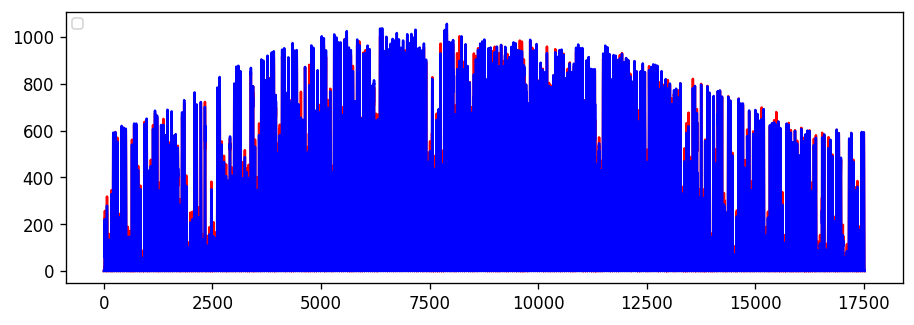

Error: 
1824.7130891022018


In [12]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# 2,0,3 ARIMA Model
exogenous = df[['Cloud Type', 'Dew Point', 'Solar Zenith Angle', 'Fill Flag', 'Surface Albedo',
       'Wind Speed', 'Precipitable Water', 'Wind Direction',
       'Relative Humidity', 'Temperature', 'Pressure']].to_numpy()
values = df.GHI.to_numpy()

#after df.GHI, add this as a parameter: exog = exogenous,
model = ARIMA(df.GHI, exog = exogenous, order=(2,0,3))
arimax = model.fit(disp=-1)
print(arimax.summary())
#model_fit.plot_predict(dynamic=False)

#after start, add this as a parameter: exog = exogenous,
forecasts = arimax.fittedvalues
forecasts = forecasts.to_numpy()
forecasts[forecasts < 0] = 0
print(forecasts[20:30])
print(values[20:30])

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.legend(loc='upper left', fontsize=8)

mean_actual = np.mean(values)

mse = mean_squared_error(values, forecasts)

plt.show()
print('Error: ')
print(mse)


In [13]:
prediction_df = pd.DataFrame(forecasts, columns =['Predictions']) 
prediction_df

,Predictions
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
17515,0.0
17516,0.0
17517,0.0
17518,0.0


In [14]:
from google.colab import files

# To look at predictions from January 1st

df['Predictions'] = prediction_df
df[24:35]

# # Write to new csv w/ predictions
df.to_csv('980023_33.89_-83.90_2019_w_ARIMAX_Preds.csv')
files.download('980023_33.89_-83.90_2019_w_ARIMAX_Preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

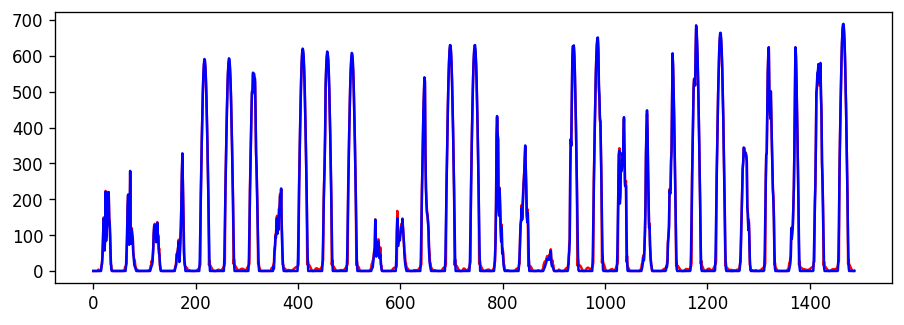

In [ ]:
jan_df = df[df['Month'] == 1]
plt.plot(jan_df.Predictions, color = 'red')
plt.plot(jan_df.GHI, color = 'blue')
plt.show()

In [ ]:
# To look at first 5 forecast predictions

length = len(df.GHI)
amt = 700
diff = length - amt
# Create Training and Test
train = df.GHI[:diff]
test = df.GHI[diff:]
print(len(train))
print(len(test))

16820
700


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
No handles with labels found to put in legend.


                              ARMA Model Results                              
Dep. Variable:                    GHI   No. Observations:                17520
Model:                     ARMA(2, 3)   Log Likelihood              -92544.131
Method:                       css-mle   S.D. of innovations             47.615
Date:                Wed, 10 Mar 2021   AIC                         185102.262
Time:                        23:44:02   BIC                         185156.660
Sample:                             0   HQIC                        185120.174
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        193.9348      5.219     37.157      0.000     183.705     204.164
ar.L1.GHI      1.8929      0.005    360.639      0.000       1.883       1.903
ar.L2.GHI     -0.9170      0.005   -185.583      0.0

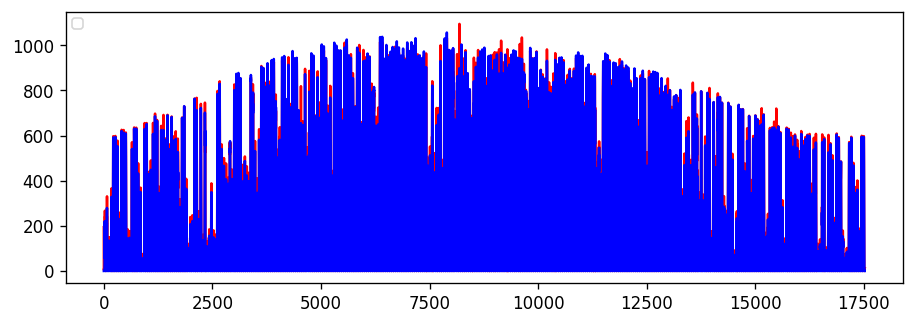

Error: 
2208.2258090079854
Difference between error w/o exog and w/ exog:
2036.6564637611714


In [ ]:
# Without exogenous
model = ARIMA(df.GHI, order=(2,0,3))
arimax = model.fit(disp=-1)
print(arimax.summary())
#model_fit.plot_predict(dynamic=False)

#after start, add this as a parameter: exog = exogenous,
forecasts = arimax.fittedvalues
forecasts = forecasts.to_numpy()
forecasts[forecasts < 0] = 0
print(forecasts[20:30])
print(values[20:30])

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.legend(loc='upper left', fontsize=8)

mean_actual = np.mean(values)

mse_before = mean_squared_error(values, forecasts)

plt.show()
print('Error: ')
print(mse_before)

print('Difference between error w/o exog and w/ exog:')
print(mse_before - mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


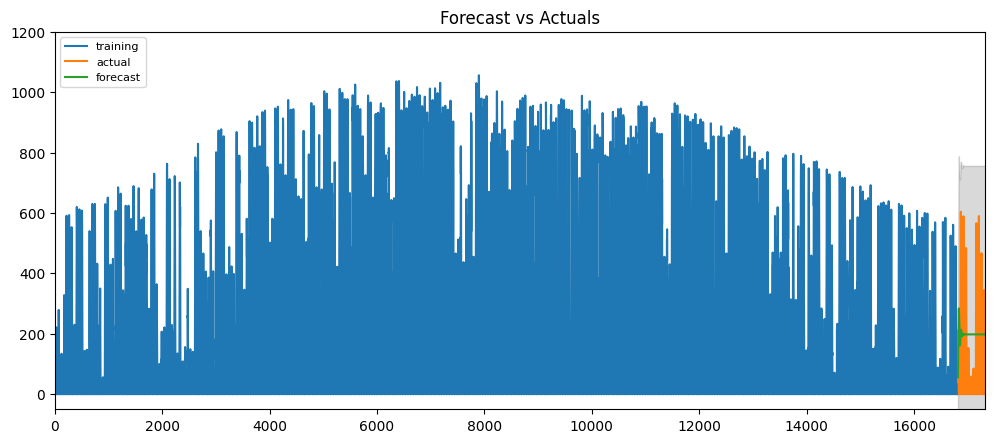

In [ ]:
# Build Model
model = ARIMA(train, order=(2, 0, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(amt, alpha=0.05)  # 95% conf
fc[fc < 0] = 0

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
fc_series = fc_series.where(fc_series > 0, 0)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xlim(0, diff + 500)
plt.ylim(-50, 1200)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Forecast
print(fc[:10])

# Actual
print(df.GHI[diff:diff + 10].to_numpy())